In [76]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline

from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay


In [33]:
# Load the dataset
df = pd.read_csv("EasyVisa.csv")
df.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [34]:
df.shape

(25480, 12)

## Data Cleaning

In [35]:
# Check for Nan values
df.isnull().sum()

case_id                  0
continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64

In [36]:
# Check for duplicates
df.duplicated().sum()

0

In [37]:
# drop case_id column
df.drop('case_id', axis=1, inplace=True)

## Feature Extraction

In [38]:
from datetime import datetime

current_date = datetime.now()
current_year = current_date.year

In [39]:
df['company_age'] = current_year - df['yr_of_estab']
df.drop('yr_of_estab', axis=1, inplace=True)

In [40]:
df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,company_age
0,Asia,High School,N,N,14513,West,592.2029,Hour,Y,Denied,19
1,Asia,Master's,Y,N,2412,Northeast,83425.6500,Year,Y,Certified,24
2,Asia,Bachelor's,N,Y,44444,West,122996.8600,Year,Y,Denied,18
3,Asia,Bachelor's,N,N,98,West,83434.0300,Year,Y,Denied,129
4,Africa,Master's,Y,N,1082,South,149907.3900,Year,Y,Certified,21


In [41]:
# Numerical features
numerical_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print("Numerical Features:", numerical_features)

Numerical Features: ['no_of_employees', 'prevailing_wage', 'company_age']


In [42]:
# Categorical features
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print("Categorical Features:", categorical_features)

Categorical Features: ['continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position', 'case_status']


In [43]:
# Discrete features
discrete_features = [feature for feature in numerical_features if len(df[feature].unique()) < 25]
print("Discrete Features:", discrete_features)
# Continuous features
continuous_features = [feature for feature in numerical_features if feature not in discrete_features]
print("Continuous Features:", continuous_features)

Discrete Features: []
Continuous Features: ['no_of_employees', 'prevailing_wage', 'company_age']


### Split train and test data

In [44]:
X = df.drop('case_status', axis=1)
y = df['case_status']

In [45]:
# Encode target feature
y = y.map({'Certified': 0, 'Denied': 1})

## Feature Transformation

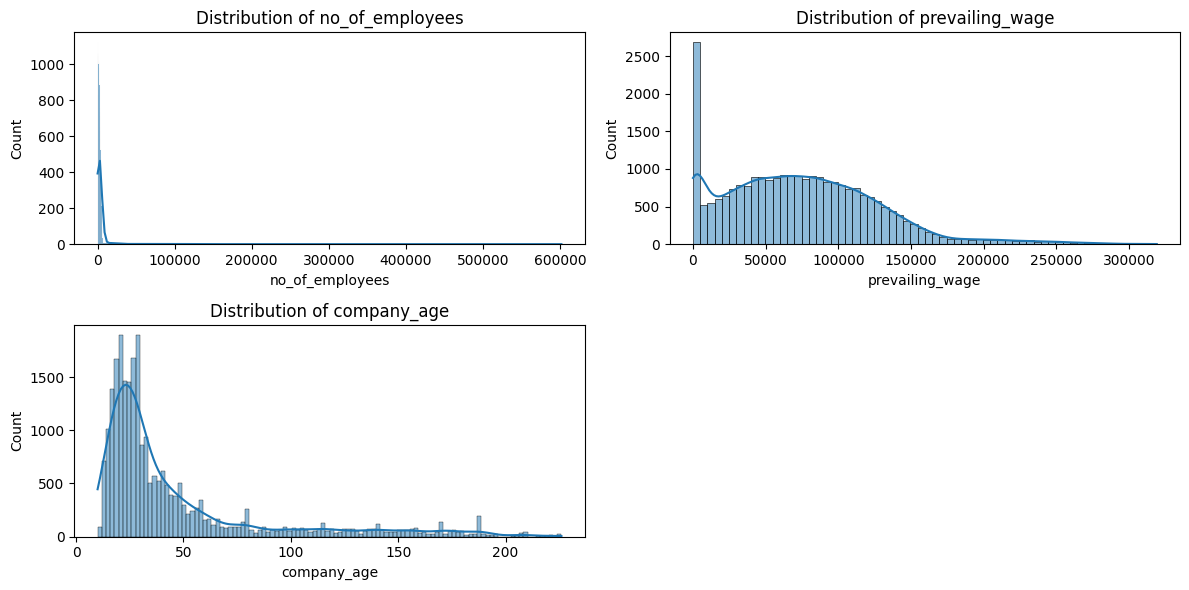

In [46]:
# Distribution of features before scaling
plt.figure(figsize=(12, 6))
for i, feature in enumerate(continuous_features):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()



In [47]:
X[continuous_features].skew()

no_of_employees    12.265260
prevailing_wage     0.755776
company_age         2.037301
dtype: float64

In [48]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer('yeo-johnson')
transform_features = ['company_age', 'no_of_employees']
X_copy = pt.fit_transform(X[transform_features])


In [49]:
X_copy = pd.DataFrame(X_copy, columns=transform_features)
X_copy.head()

,company_age,no_of_employees
0,-0.958506,1.517300
1,-0.470816,0.030912
2,-1.080479,2.885076
3,1.632700,-1.343550
4,-0.741917,-0.432287


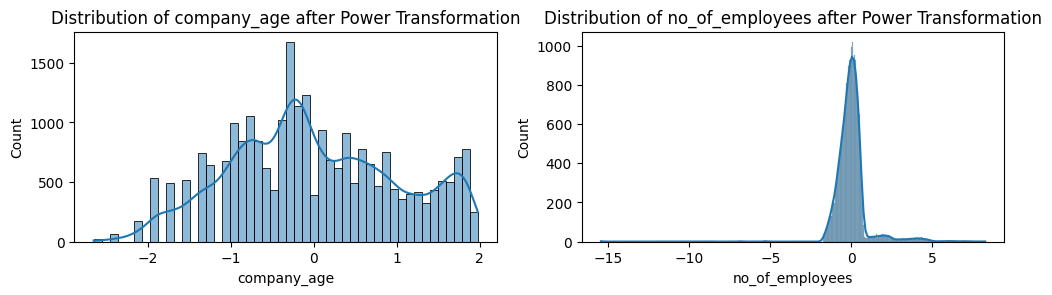

In [50]:
# Plot distribution after transformation
plt.figure(figsize=(12, 6))
for i, feature in enumerate(transform_features):
    plt.subplot(2, 2, i + 1)
    sns.histplot(X_copy[feature], kde=True)
    plt.title(f'Distribution of {feature} after Power Transformation')

In [51]:
X_copy.skew(axis=0, skipna=True)

company_age        0.120823
no_of_employees    0.399339
dtype: float64

In [52]:
for feature in categorical_features:
    print("Feature:", feature)
    print(df[feature].nunique())
    print(df[feature].value_counts())
    print("="*40)

Feature: continent
6
continent
Asia             16861
Europe            3732
North America     3292
South America      852
Africa             551
Oceania            192
Name: count, dtype: int64
Feature: education_of_employee
4
education_of_employee
Bachelor's     10234
Master's        9634
High School     3420
Doctorate       2192
Name: count, dtype: int64
Feature: has_job_experience
2
has_job_experience
Y    14802
N    10678
Name: count, dtype: int64
Feature: requires_job_training
2
requires_job_training
N    22525
Y     2955
Name: count, dtype: int64
Feature: region_of_employment
5
region_of_employment
Northeast    7195
South        7017
West         6586
Midwest      4307
Island        375
Name: count, dtype: int64
Feature: unit_of_wage
4
unit_of_wage
Year     22962
Hour      2157
Week       272
Month       89
Name: count, dtype: int64
Feature: full_time_position
2
full_time_position
Y    22773
N     2707
Name: count, dtype: int64
Feature: case_status
2
case_status
Certified    170

## Feature Encoding

In [53]:
numerical_features

['no_of_employees', 'prevailing_wage', 'company_age']

In [54]:
# Create Column Transformer with 3 types of transformers
ordinal_columns = ['has_job_experience','requires_job_training','full_time_position','education_of_employee']
onehot_columns = ['continent','unit_of_wage','region_of_employment']
transform_columns= ['no_of_employees','company_age']


numeric_transformer = StandardScaler()
onehot_transformer = OneHotEncoder()
ordinal_encoder = OrdinalEncoder()

transform_pipe = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", onehot_transformer, onehot_columns),
        ("Ordinal_Encoder", ordinal_encoder, ordinal_columns),
        ("Transformer", transform_pipe, transform_columns),
        ("StandardScaler", numeric_transformer, numerical_features)
    ]
)

In [55]:
X = preprocessor.fit_transform(X)

X

array([[ 0.        ,  1.        ,  0.        , ...,  0.38666657,
        -1.39853722, -0.65122993],
       [ 0.        ,  1.        ,  0.        , ..., -0.14228155,
         0.1698353 , -0.53321103],
       [ 0.        ,  1.        ,  0.        , ...,  1.69498375,
         0.91907852, -0.6748337 ],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.19871259,
         1.36027953,  1.63833662],
       [ 0.        ,  1.        ,  0.        , ..., -0.16387483,
         0.22150859,  2.18122353],
       [ 0.        ,  1.        ,  0.        , ..., -0.10805575,
        -0.06776315,  0.45814768]])

In [59]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTEENN(random_state=42,sampling_strategy='minority' )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X, y)

In [60]:
from sklearn.model_selection import  train_test_split
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((13644, 24), (3412, 24))

## Model Training & Eval

In [62]:
# function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")

In [ ]:
# models to train
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
     "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()

}

In [64]:
# function to evaluate models
def evaluate_models(models, X_train, y_train, X_test, y_test):
    for name, model in models.items():
        print(f"Training {name} Model...")
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        print(f"Evaluation Metrics for {name}:")
        print("Training Set Metrics:")
        calculate_metrics(y_train, y_train_pred)
        print("-"*50)
        print("Test Set Metrics:")
        calculate_metrics(y_test, y_test_pred)
        print("="*50)

    report = pd.DataFrame({
        "Model": list(models.keys()),
        "Accuracy": [accuracy_score(y_test, model.predict(X_test)) for model in models.values()],
        "Precision": [precision_score(y_test, model.predict(X_test)) for model in models.values()],
        "Recall": [recall_score(y_test, model.predict(X_test)) for model in models.values()],
        "F1 Score": [f1_score(y_test, model.predict(X_test)) for model in models.values()],
        "ROC AUC Score": [roc_auc_score(y_test, model.predict(X_test)) for model in models.values()]
    })
    return report


In [65]:
model_reports = evaluate_models(models, X_train, y_train, X_test, y_test)

Training Random Forest Model...
Evaluation Metrics for Random Forest:
Training Set Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC Score: 1.0000
--------------------------------------------------
Test Set Metrics:
Accuracy: 0.9543
Precision: 0.9592
Recall: 0.9561
F1 Score: 0.9577
ROC AUC Score: 0.9541
Training Decision Tree Model...
Evaluation Metrics for Decision Tree:
Training Set Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC Score: 1.0000
--------------------------------------------------
Test Set Metrics:
Accuracy: 0.9241
Precision: 0.9348
Recall: 0.9242
F1 Score: 0.9294
ROC AUC Score: 0.9241
Training Gradient Boosting Model...
Evaluation Metrics for Gradient Boosting:
Training Set Metrics:
Accuracy: 0.8860
Precision: 0.8941
Recall: 0.8946
F1 Score: 0.8944
ROC AUC Score: 0.8852
--------------------------------------------------
Test Set Metrics:
Accuracy: 0.8933
Precision: 0.9040
Recall: 0.8982
F1 Score: 0.90

In [67]:
model_reports.sort_values(by='F1 Score', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,Random Forest,0.954279,0.959239,0.956121,0.957678,0.954114
4,K-Neighbors Classifier,0.941090,0.933123,0.959913,0.946328,0.939407
5,XGBClassifier,0.936401,0.943386,0.938787,0.941081,0.936188
6,CatBoosting Classifier,0.928195,0.948962,0.916576,0.932488,0.929233
1,Decision Tree,0.924091,0.934795,0.924160,0.929447,0.924085
2,Gradient Boosting,0.893318,0.904035,0.898158,0.901087,0.892885
7,Support Vector Classifier,0.873681,0.891100,0.873239,0.882079,0.873721
8,AdaBoost Classifier,0.860785,0.878520,0.861863,0.870112,0.860689
3,Logistic Regression,0.737104,0.768231,0.736186,0.751867,0.737186


### Hyperparameter tuning

In [68]:
#Initialize few parameters for Hyperparamter tuning fot top 3 models based on F1 Score
xgboost_params = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

rf_params = {
    "max_depth": [10, 12, None, 15, 20],
    "max_features": ['sqrt', 'log2', None],
    "n_estimators": [10, 50, 100, 200]
}

knn_params = {
    "algorithm": ['auto', 'ball_tree', 'kd_tree','brute'],
    "weights": ['uniform', 'distance'],
    "n_neighbors": [3, 4, 5, 7, 9],
}

In [69]:
# Models list for Hyperparameter tuning
randomcv_models = [
    ('XGBoost', XGBClassifier(), xgboost_params),
    ("RF", RandomForestClassifier(), rf_params),
    ("KNN", KNeighborsClassifier(), knn_params)
]

In [70]:
model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2, 
                                   n_jobs=-1)
    random.fit(X_res, y_res)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
---------------- Best Params for XGBoost -------------------
{'min_child_weight': 1, 'max_depth': 9}
---------------- Best Params for RF -------------------
{'n_estimators': 200, 'max_features': 'log2', 'max_depth': None}
---------------- Best Params for KNN -------------------
{'weights': 'distance', 'n_neighbors': 4, 'algorithm': 'auto'}


In [71]:
model_param

{'XGBoost': {'min_child_weight': 1, 'max_depth': 9},
 'RF': {'n_estimators': 200, 'max_features': 'log2', 'max_depth': None},
 'KNN': {'weights': 'distance', 'n_neighbors': 4, 'algorithm': 'auto'}}

In [72]:
best_models = {
    "Random Forest Classifier": RandomForestClassifier(**model_param['RF']),
    "KNeighborsClassifier": KNeighborsClassifier(**model_param['KNN']),
    "XGBClassifier": XGBClassifier(**model_param['XGBoost'],n_jobs=-1),
}

tuned_report =evaluate_models(best_models, X_train, y_train, X_test, y_test)

Training Random Forest Classifier Model...
Evaluation Metrics for Random Forest Classifier:
Training Set Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC Score: 1.0000
--------------------------------------------------
Test Set Metrics:
Accuracy: 0.9540
Precision: 0.9567
Recall: 0.9583
F1 Score: 0.9575
ROC AUC Score: 0.9536
Training KNeighborsClassifier Model...
Evaluation Metrics for KNeighborsClassifier:
Training Set Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC Score: 1.0000
--------------------------------------------------
Test Set Metrics:
Accuracy: 0.9719
Precision: 0.9620
Recall: 0.9870
F1 Score: 0.9743
ROC AUC Score: 0.9705
Training XGBClassifier Model...
Evaluation Metrics for XGBClassifier:
Training Set Metrics:
Accuracy: 0.9994
Precision: 0.9993
Recall: 0.9996
F1 Score: 0.9995
ROC AUC Score: 0.9994
--------------------------------------------------
Test Set Metrics:
Accuracy: 0.9461
Precision: 0.9521
R

In [74]:
tuned_report.sort_values(by='F1 Score', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
1,KNeighborsClassifier,0.971864,0.961985,0.986999,0.974332,0.970511
0,Random Forest Classifier,0.953986,0.956733,0.958288,0.957510,0.953601
2,XGBClassifier,0.946073,0.952122,0.947996,0.950054,0.945901


In [75]:
best_model = KNeighborsClassifier(**model_param['KNN'])
best_model = best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test,y_pred)
cr = classification_report(y_test,y_pred)

print("FINAL MODEL 'KNN'")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

FINAL MODEL 'KNN'
Accuracy Score value: 0.9719
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1566
           1       0.96      0.99      0.97      1846

    accuracy                           0.97      3412
   macro avg       0.97      0.97      0.97      3412
weighted avg       0.97      0.97      0.97      3412



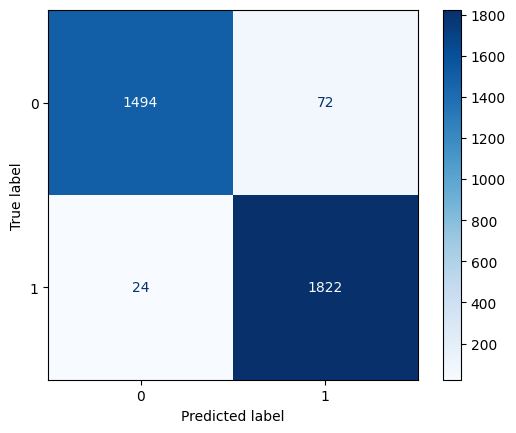

In [77]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test,cmap='Blues')